# Chapter 14: Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(broom.mixed)
library(rstanarm)
library(tidybayes)
library(ggmosaic)
library(e1071)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: Rcpp

This is rstanarm version 2.21.4

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equ

## Exercise 14.4

### a)

In [2]:
head( fake_news %>% select( type, title_has_excl ) )

,type,title_has_excl
,<fct>,<lgl>
1,fake,FALSE
2,real,FALSE
3,fake,TRUE
4,real,FALSE
5,fake,FALSE
6,real,FALSE


Mosaic plot:

Warning message:
“`unite_()` was deprecated in tidyr 1.2.0.
ℹ Please use `unite()` instead.
ℹ The deprecated feature was likely used in the ggmosaic package.
  Please report the issue at <https://github.com/haleyjeppson/ggmosaic>.”


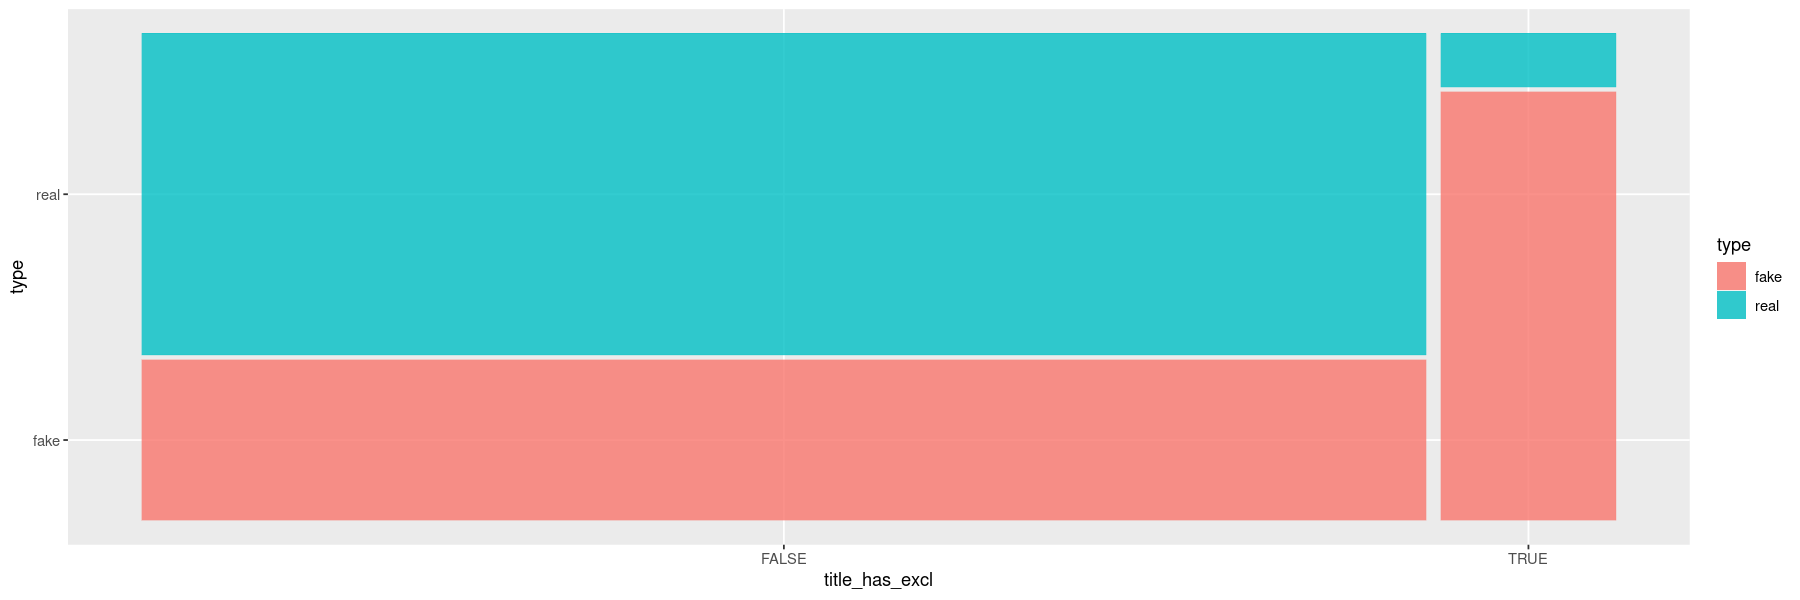

In [3]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=fake_news ) + geom_mosaic( aes(x=product(type, title_has_excl), fill=type) )

It appears that if there is an exclamation mark in the title, it is much more likely that the article is fake.

### b)

Prior $P(\text{real})$:

In [4]:
fake_news %>% 
    summarize( real_prop=mean(type=="real"))

real_prop
<dbl>
0.6


Likelihood $P(\bar{!}|\text{real})$:

In [5]:
fake_news %>% 
    filter( type=="real" ) %>% 
    summarize( has_no_excl_prop=mean(!title_has_excl))

has_no_excl_prop
<dbl>
0.9777778


Evidence $P(\bar{!})$:

In [6]:
fake_news %>% 
    summarize( has_no_excl_prop=mean(title_has_excl==FALSE))

has_no_excl_prop
<dbl>
0.88


Posterior: 
$$P(\text{real}|\bar{!}) = \frac{P(\bar{!}|\text{real}) \, P(\text{real})}{P(\bar{!})}$$

In [7]:
0.6 * 0.9777777777 / 0.88

[1] 0.6666667

The article is predicted to be real.

### c)

In [8]:
news_model_1 <- naiveBayes(type ~ title_has_excl, data=fake_news)
pred <- predict( news_model_1, newdata=data.frame(title_has_excl=FALSE), type="raw" )
pred

fake,real
0.3333333,0.6666667


The predictions match.

## Exercise 14.5

### a)

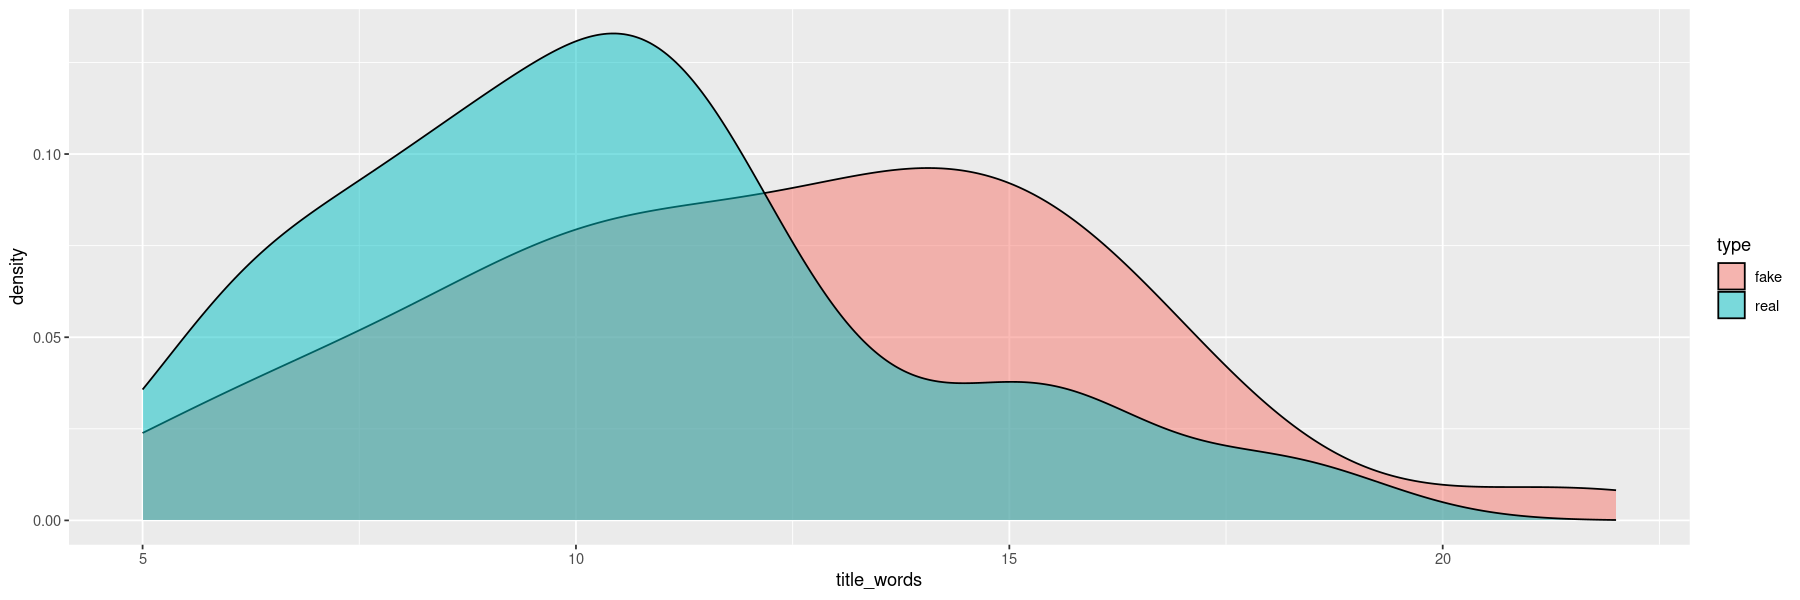

In [9]:
ggplot( fake_news ) + geom_density( aes(x=title_words, fill=type), alpha=0.5 )

Fake articles appear to have more words in the title.

### b)

The density plots above do not look normal. Visualize separately as histograms to make sure it's not density plot artefacts:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


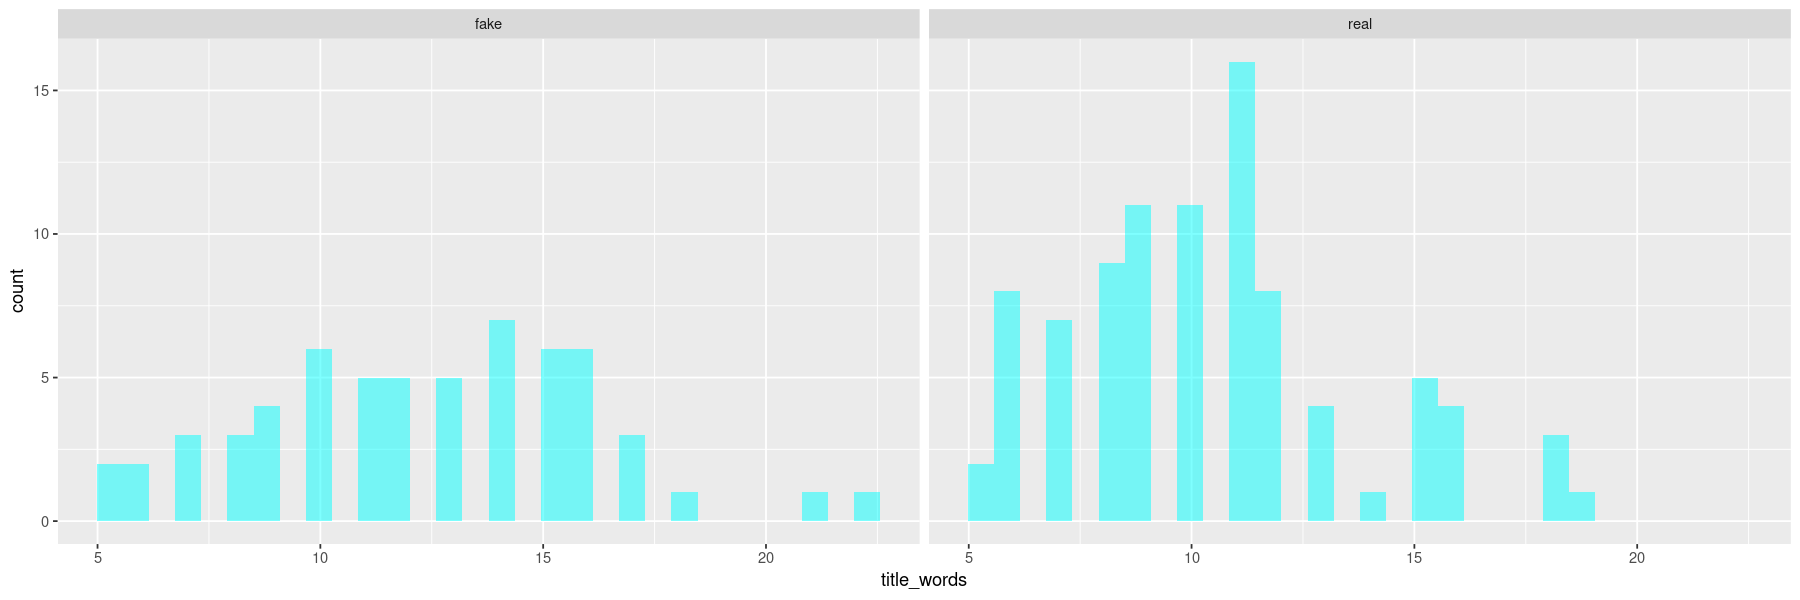

In [10]:
ggplot( fake_news ) + geom_histogram( aes(x=title_words), fill="cyan", alpha=0.5 ) + facet_wrap(~type)

Q-Q plot for real news:

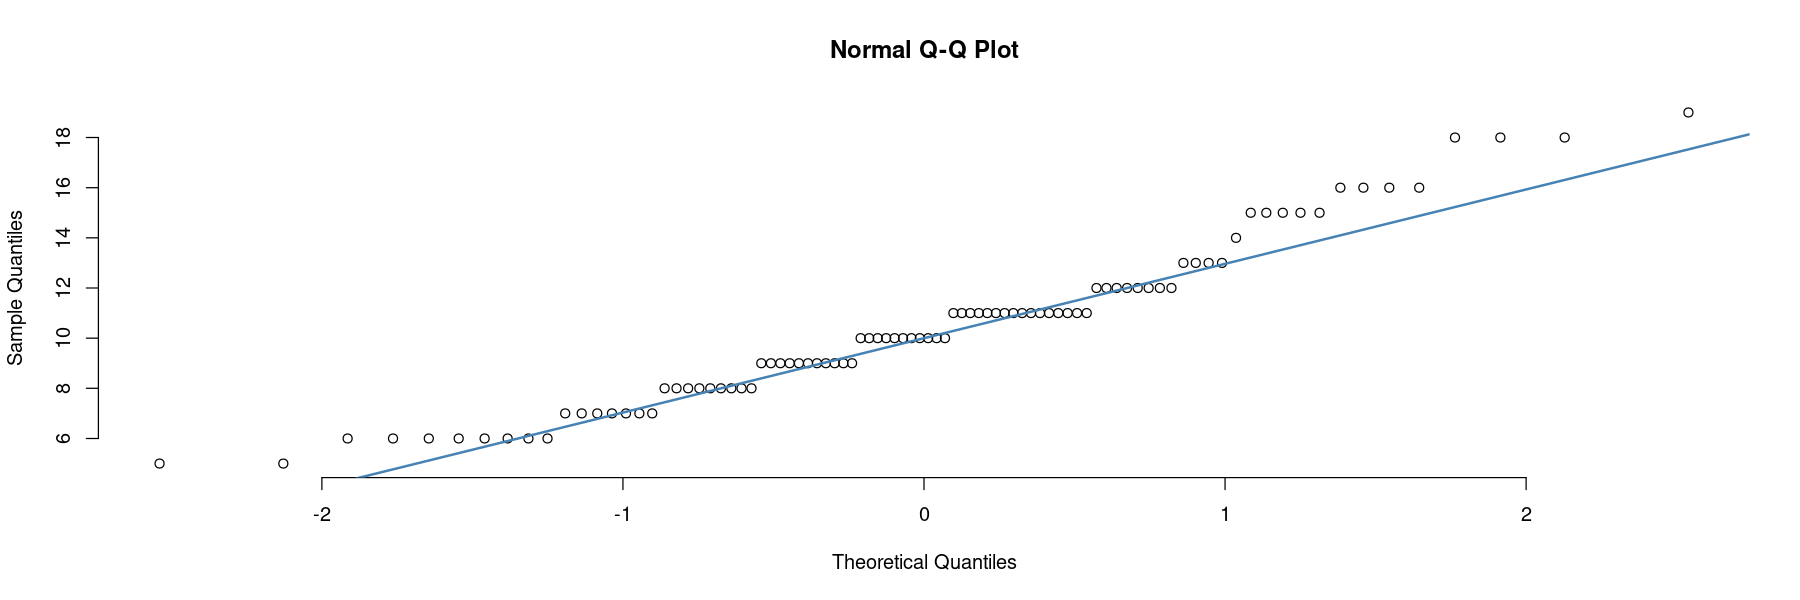

In [11]:
qqnorm(fake_news[fake_news$type=="real",]$title_words, pch = 1, frame = FALSE)
qqline(fake_news[fake_news$type=="real",]$title_words, col = "steelblue", lwd = 2)

Q-Q plot for fake news:

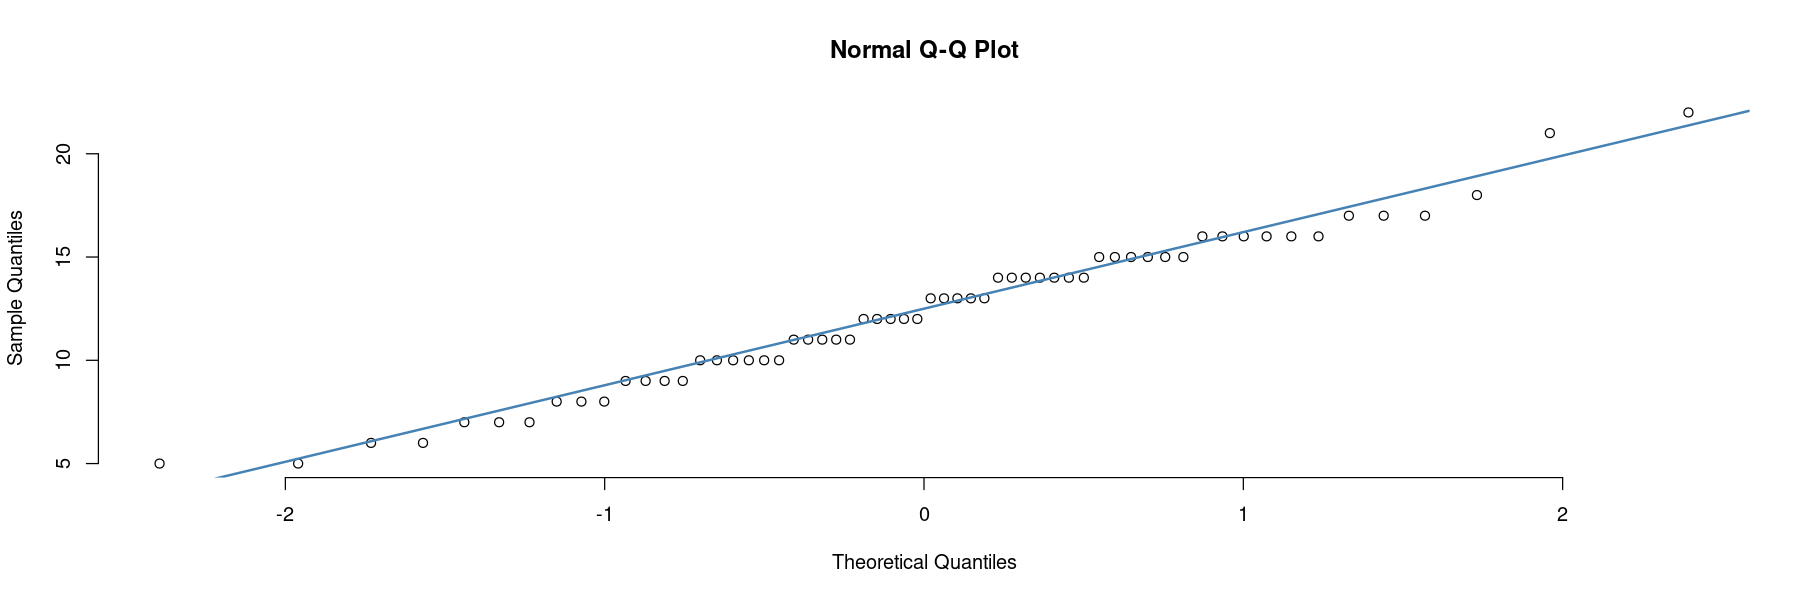

In [12]:
qqnorm(fake_news[fake_news$type=="fake",]$title_words, pch = 1, frame = FALSE)
qqline(fake_news[fake_news$type=="fake",]$title_words, col = "steelblue", lwd = 2)

The histograms look roughly normal with a few outliers. Let's see whether the assumption of normality brings reasonable results.

### c)

Priors $P(\text{real})$ and $P(\text{fake})$:

In [13]:
fake_news %>% 
    summarize( real_prop=mean(type=="real"), fake_prop=mean(type=="fake"))

real_prop,fake_prop
<dbl>,<dbl>
0.6,0.4


Likelihoods $P(\text{15 words}|\text{real})$ and $P(\text{15 words}|\text{fake})$:

In [14]:
fake_news %>% 
    filter( type=="real" ) %>% 
    summarize( mean_words=mean(title_words), sd_words=sd(title_words) )

mean_words,sd_words
<dbl>,<dbl>
10.42222,3.204554


In [15]:
p15words.real <- dnorm( 15, mean=10.42222, sd=3.204554 )
p15words.real

[1] 0.04487606

In [16]:
fake_news %>% 
    filter( type=="fake" ) %>% 
    summarize( mean_words=mean(title_words), sd_words=sd(title_words) )

mean_words,sd_words
<dbl>,<dbl>
12.31667,3.743884


In [17]:
p15words.fake <- dnorm( 15, mean=12.31667, sd=3.743884 )
p15words.fake

[1] 0.08242154

Evidence $P(\text{15 words}) = P(\text{15 words}|\text{real}) \, P(\text{real}) + P(\text{15 words}|\text{fake}) \, P(\text{fake})$:

In [18]:
evidence <- p15words.real * 0.6 + p15words.fake * 0.4
evidence

[1] 0.05989425

Posterior $P(\text{real}|\text{15 words}) = \frac{P(\text{15 words}|\text{real}) \, P(\text{real})}{P(\text{15 words})}$:

In [19]:
p15words.real*0.6 / evidence

[1] 0.4495529

The article is predicted to be slightly more fake than real, though a boundary case.

### d)

In [20]:
news_model_2 <- naiveBayes(type ~ title_words, data=fake_news)
pred <- predict( news_model_2, newdata=data.frame(title_words=15), type="raw" )
pred

fake,real
0.5504467,0.4495533


The predictions match - `naiveBayes` makes it much simpler.

## Exercise 14.6

### a)

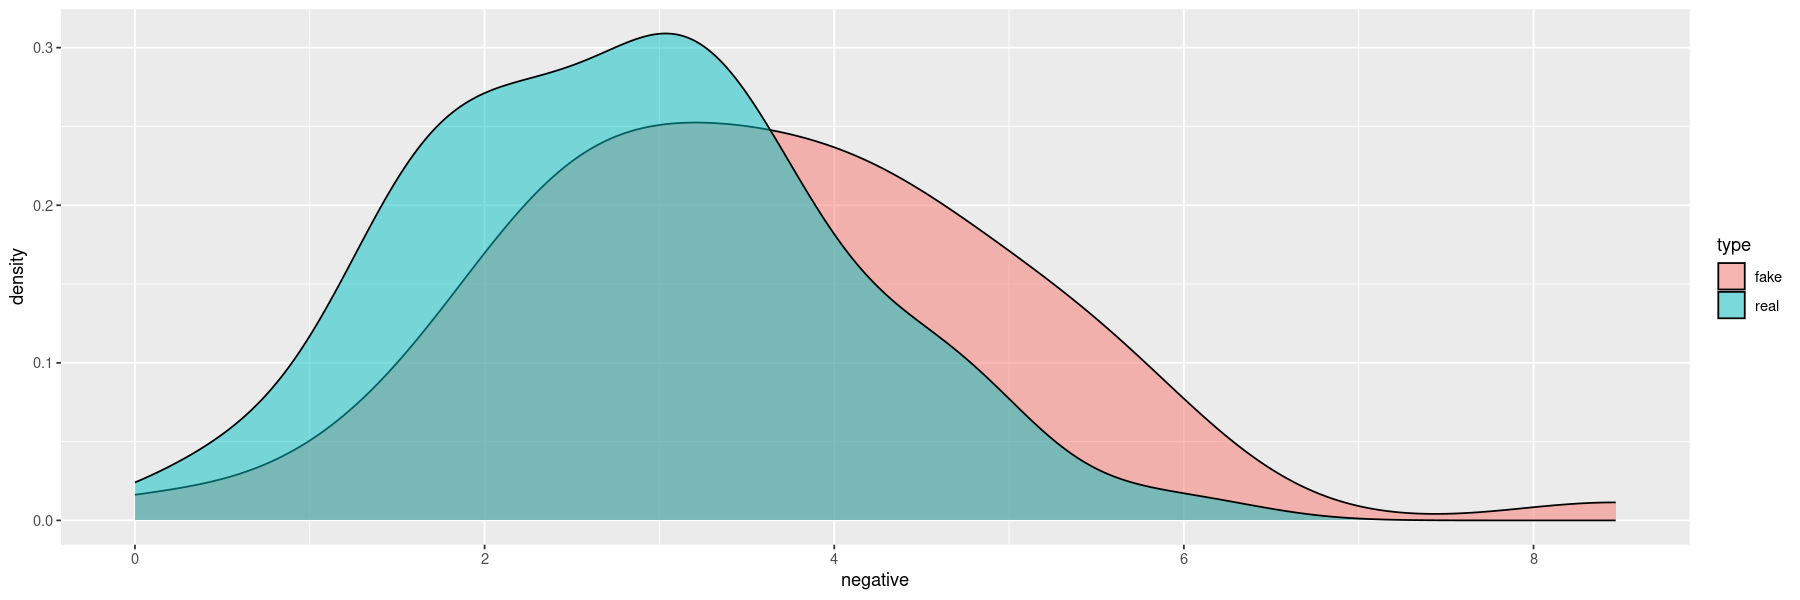

In [21]:
ggplot( fake_news ) + geom_density( aes(x=negative, fill=type), alpha=0.5 )

It appears that fake articles have slightly more words with negative sentiments. Conditional normality seems to be an ok assumption.

### b)

`geom_smooth()` using formula = 'y ~ x'


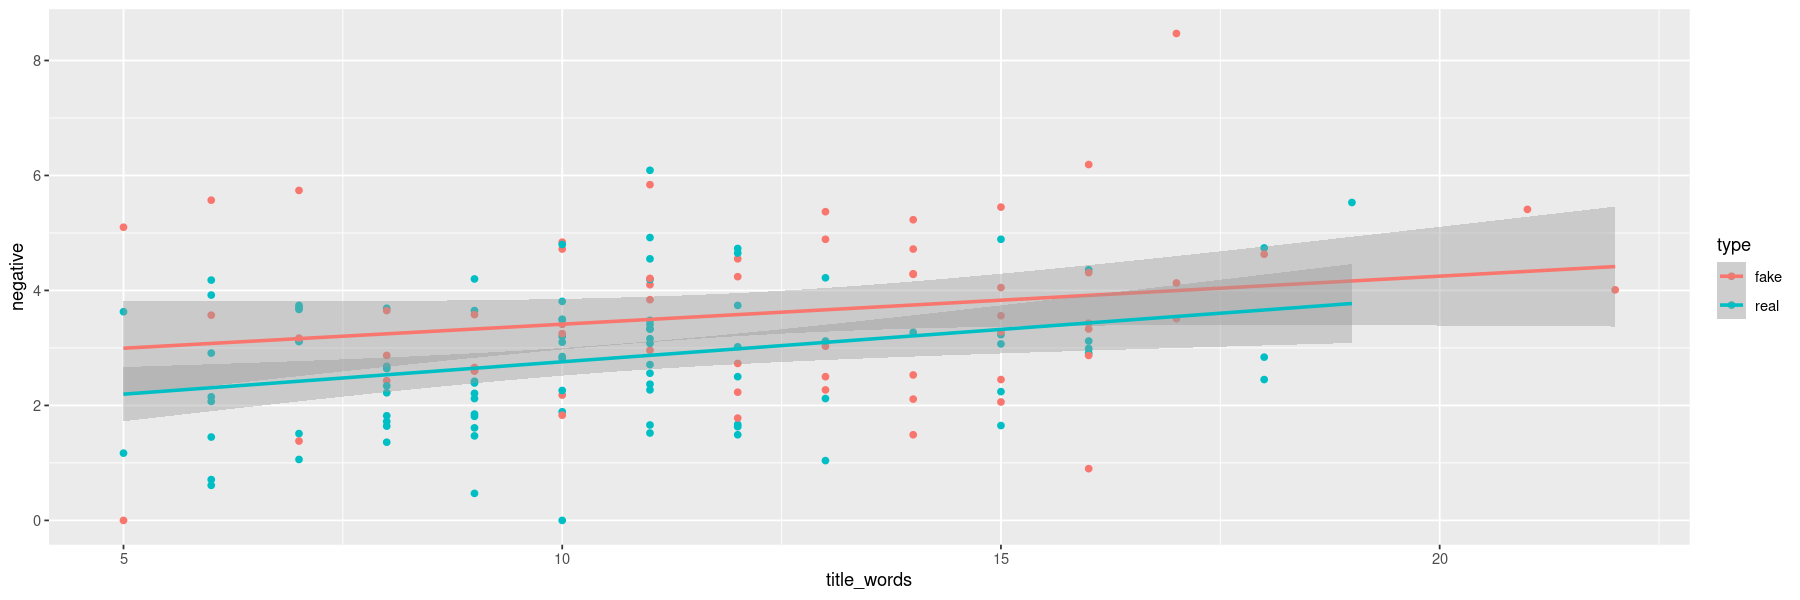

In [22]:
ggplot( fake_news, aes(x=title_words, y=negative, color=type) ) + geom_point() + geom_smooth( method="lm" )

There appears to be a slight correlation between number of words and percentage of words with negative sentiment. However this correlation is rather weak (raised from 2 to 4% between 5 and 20 words).

### c)

Naive Bayes:

$$P(\text{real}|\text{15 words, 6% negative}) = \frac{P(\text{15 words, 6% negative}|\text{real}) \, P(\text{real})}{P(\text{15 words, 6% negative})} = \frac{P(\text{15 words}|\text{real}) \, P(\text{6% negative}|\text{real})\,P(\text{real})}{P(\text{15 words, 6% negative})}$$

with evidence

$$
\begin{eqnarray}
P(\text{15 words, 6% negative}) &=& P(\text{15 words, 6% negative}|\text{real}) \, P(\text{real}) + P(\text{15 words, 6% negative}|\text{fake}) \, P(\text{fake})\\
&=& P(\text{15 words}|\text{real}) \, P(\text{6% negative}|\text{real}) \, P(\text{real}) + P(\text{15 words}|\text{fake}) \, P(\text{6% negative}|\text{fake}) \, P(\text{fake})
\end{eqnarray}
$$


We know $P(\text{real})$, $P(\text{fake})$, $P(\text{15 words}|\text{real})$ and $P(\text{15 words}|\text{fake})$ from the previous exercises.

Likelihood for 6% negative:

In [23]:
fake_news %>% 
    group_by( type ) %>% 
    summarize( mean=mean(negative), sd=sd(negative) )

type,mean,sd
<fct>,<dbl>,<dbl>
fake,3.606333,1.466429
real,2.806556,1.190917


In [24]:
p6negative.real <- dnorm( 6, mean=2.806556, sd=1.190917 )
p6negative.real

[1] 0.00919695

In [25]:
p6negative.fake <- dnorm( 6, mean=3.606333, sd=1.466429 )
p6negative.fake

[1] 0.07179166

Evidence:

In [26]:
evidence <- p6negative.real * p15words.real * 0.6 + p15words.fake * p6negative.fake * 0.4
evidence

[1] 0.002614505

Compute posterior:

In [27]:
posterior <- p15words.real * p6negative.real * 0.6 / evidence
posterior

[1] 0.09471532

The article is predicted to be fake.

### d)

In [28]:
news_model_3 <- naiveBayes(type ~ title_words + negative, data=fake_news)
pred <- predict( news_model_3, newdata=data.frame(title_words=15, negative=6), type="raw" )
pred

fake,real
0.9052846,0.09471539


The same result, with much less code..

## Exercise 14.7

(happy I can use `naiveBayes()` now..)

In [29]:
news_model_4 <- naiveBayes(type ~ title_words + negative + title_has_excl, data=fake_news)
pred <- predict( news_model_4, newdata=data.frame(title_words=15, negative=6, title_has_excl=FALSE), type="raw" )
pred

fake,real
0.8775779,0.1224221


The article is predicted to be fake.

## Exercise 14.8

### a)

In [30]:
cv_model_1 <- naive_classification_summary_cv( model=news_model_1, data=fake_news, y="type", k=10)
cv_model_1$cv

,type,fake,real
,<fct>,<chr>,<chr>
1,fake,26.67% (16),73.33% (44)
2,real,2.22% (2),97.78% (88)


### b)

The ground truth is in the columns and the predictions are in the rows. Assuming that real is positive, the model has 98% true positives, 27% true negatives, 2% false positives and 73% false negatives. This means that the model has a low sensivity and classifies probably too many articles as fake even though they are not. Probably an exclamation mark alone is not the best estimator.

### c)

In [31]:
cv_model_1 <- naive_classification_summary_cv( model=news_model_1, data=fake_news, y="type", k=10)
cv_model_1$cv

,type,fake,real
,<fct>,<chr>,<chr>
1,fake,26.67% (16),73.33% (44)
2,real,2.22% (2),97.78% (88)


specificity:

In [32]:
16/(16+2)

[1] 0.8888889

In [33]:
cv_model_2 <- naive_classification_summary_cv( model=news_model_2, data=fake_news, y="type", k=10)
cv_model_2$cv

,type,fake,real
,<fct>,<chr>,<chr>
1,fake,33.33% (20),66.67% (40)
2,real,15.56% (14),84.44% (76)


specificity:

In [34]:
20/(20+13)

[1] 0.6060606

In [35]:
cv_model_3 <- naive_classification_summary_cv( model=news_model_3, data=fake_news, y="type", k=10)
cv_model_3$cv

,type,fake,real
,<fct>,<chr>,<chr>
1,fake,41.67% (25),58.33% (35)
2,real,20.00% (18),80.00% (72)


specificity:

In [36]:
27/(27+17)

[1] 0.6136364

In [37]:
cv_model_4 <- naive_classification_summary_cv( model=news_model_4, data=fake_news, y="type", k=10)
cv_model_4$cv

,type,fake,real
,<fct>,<chr>,<chr>
1,fake,48.33% (29),51.67% (31)
2,real,15.56% (14),84.44% (76)


specificity:

In [38]:
29/(29+10)

[1] 0.7435897

### d)

A model that best detects when an article is fake (assuming fake is negative) has a high specificity (true negative rate). Model 1 has the highest sensitivity.

## Exercise 14.9

### a)

Prior for intercept (around 60% real, maybe between 10-90% could be a good uncertainty rage):

In [39]:
log(0.6/(1-0.6))

[1] 0.4054651

In [40]:
log(0.1/(1-0.1))

[1] -2.197225

In [41]:
log(0.9/(1-0.9))

[1] 2.197225

Uncertainty:

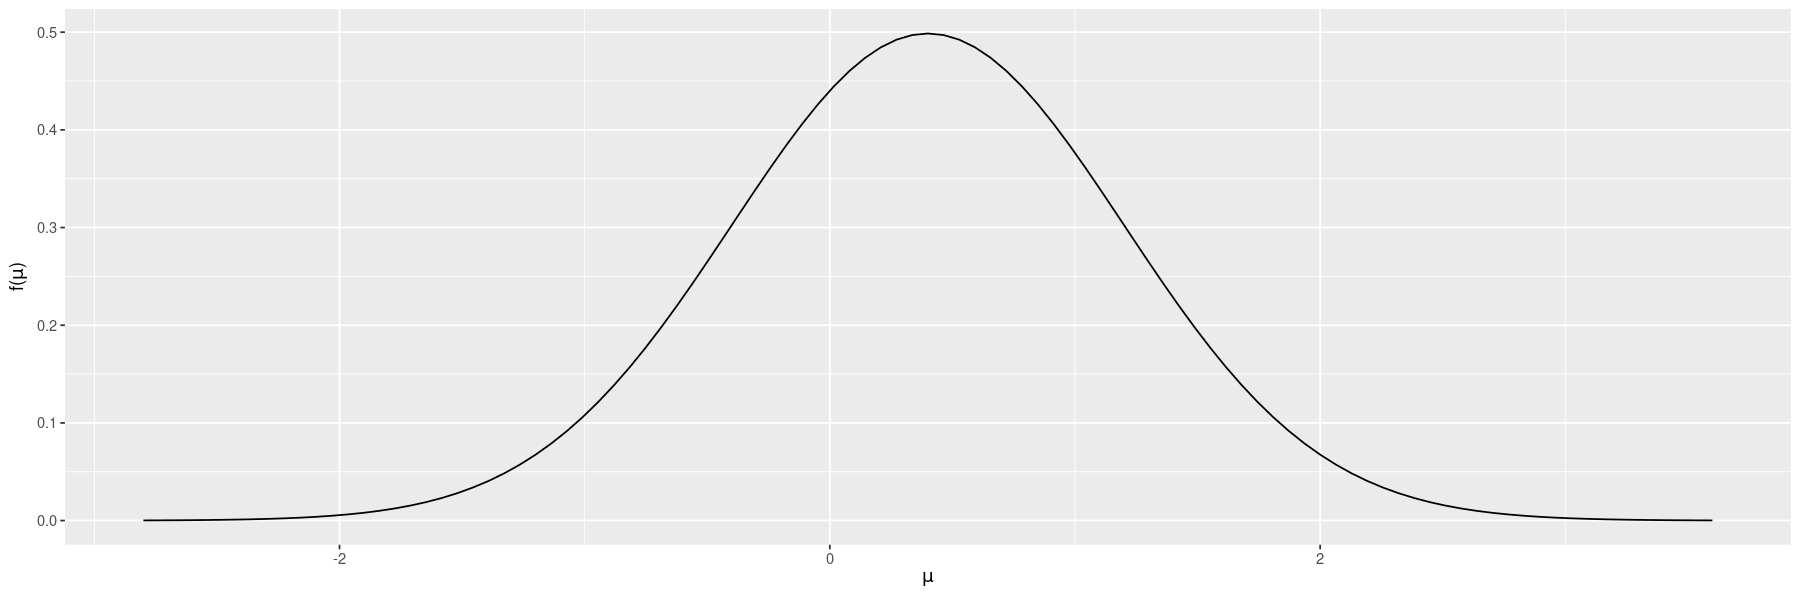

In [42]:
plot_normal( mean=0.4, sd=0.8 )

In [43]:
news_model_5 <- stan_glm(
  type ~ title_words + negative + title_has_excl,
  data = fake_news %>% mutate( type=ifelse(type=="real",1,0)), # for interpretation purposes, make sure real is positive
  family = binomial,
  prior_intercept = normal(0.4, 0.8),
  prior = normal(0, 1, autoscale = TRUE), 
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.187093 seconds (Warm-up)
Chain 1:                0.219128 seconds (Sampling)
Chain 1:  

### b)

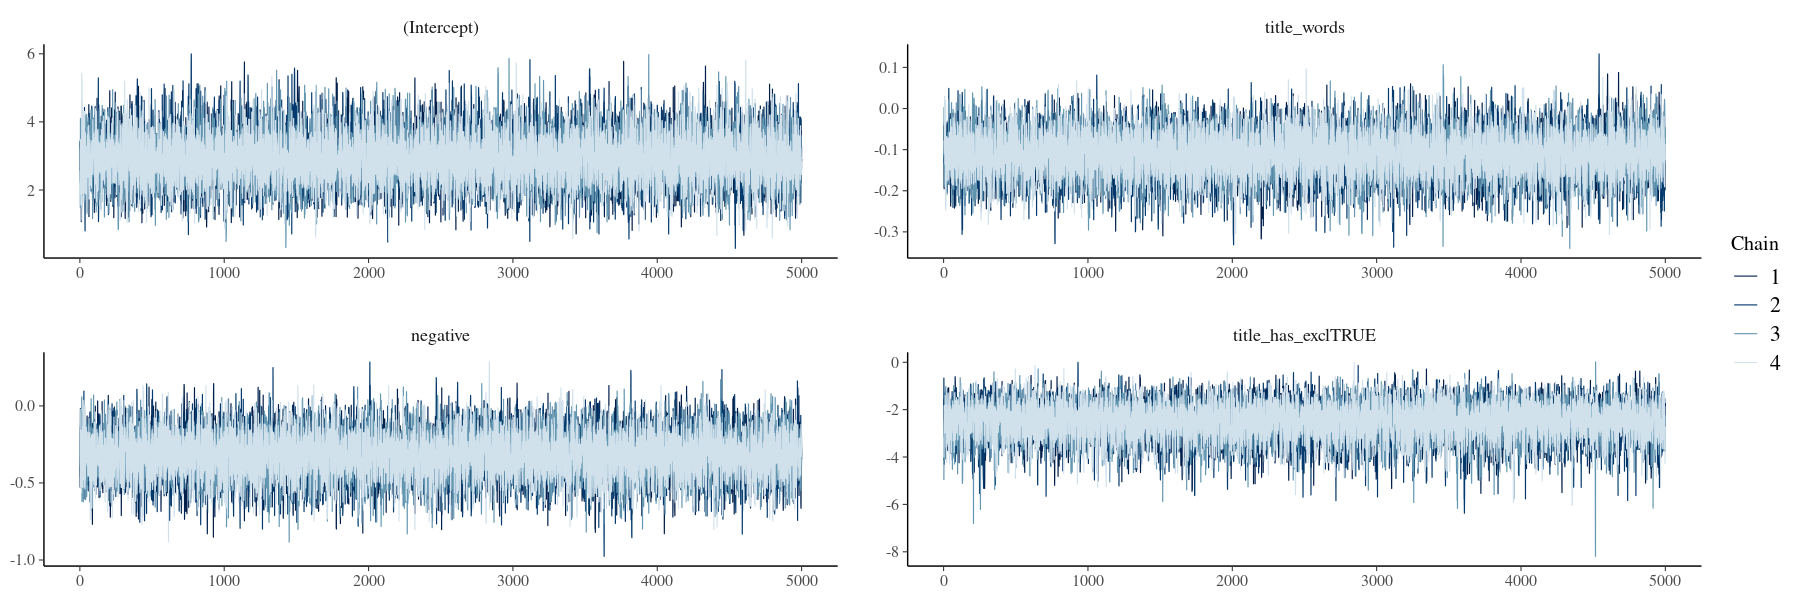

In [44]:
mcmc_trace( news_model_5 )

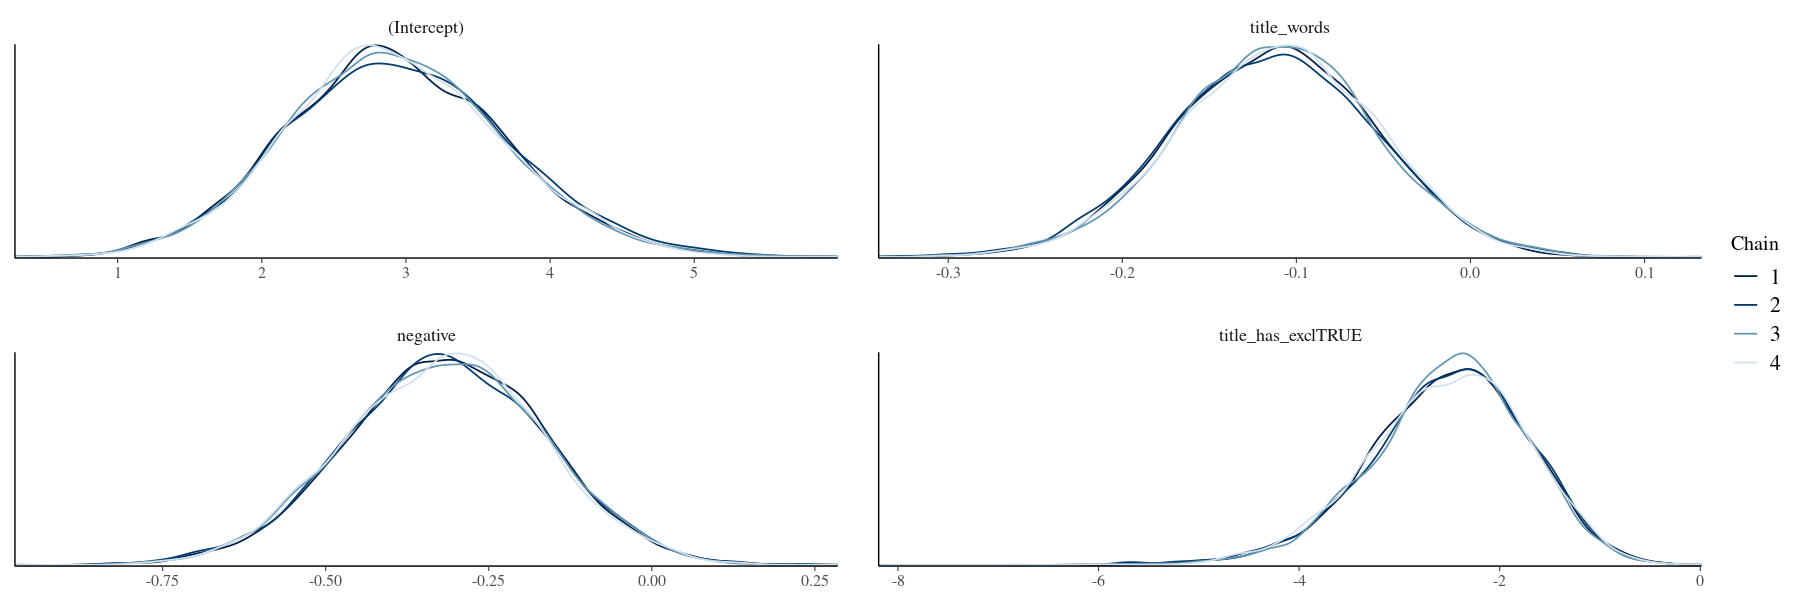

In [45]:
mcmc_dens_overlay( news_model_5 )

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>.”


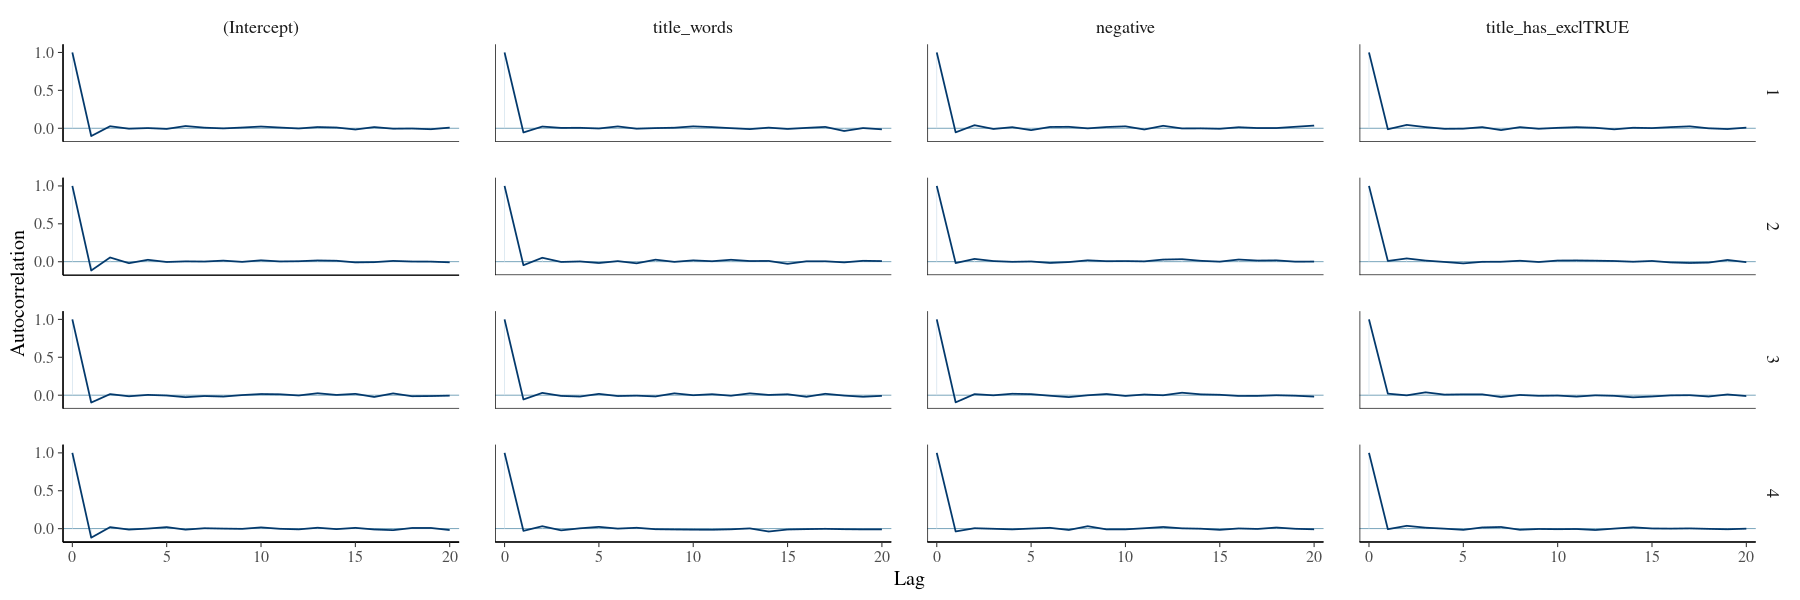

In [46]:
mcmc_acf( news_model_5 )

Looks like the model is mixing quickly!

### c)

Warning message:
“'nreps' is ignored for this PPC”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


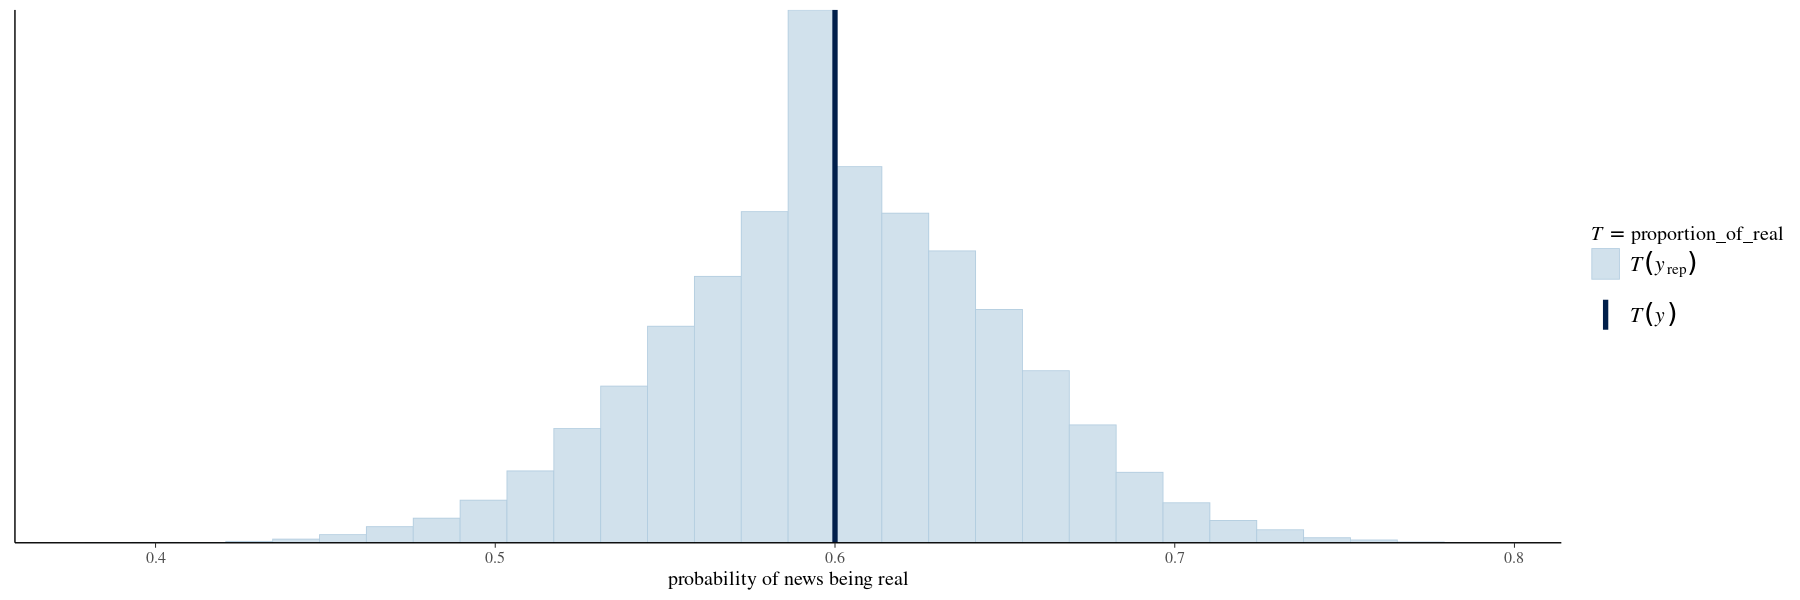

In [47]:
proportion_of_real <- function(x){mean(x == 1)}
pp_check(news_model_5, nreps = 100,
         plotfun = "stat", stat = "proportion_of_real") + xlab("probability of news being real")

The model generates posterior probabilities between 0.5 and 0.7. Looks broad, however the reason for this is that we only have 150 data points and very broad priors.

### d)

In [48]:
cv_model_5 <- classification_summary_cv(model = news_model_5, data = fake_news, cutoff = 0.5, k = 10)
cv_model_5$cv

sensitivity,specificity,overall_accuracy
<dbl>,<dbl>,<dbl>
0.9032828,0.4128571,0.7066667


### e)

The logistic regression model has a higher sensitivity than specificity and is therefore better at detecting real news. Consequently naïve Bayes model 4 is better at detecting fake news. 

## Exercise 14.10

### Select predictors

In [49]:
head(pulse_of_the_nation)

income,age,party,trump_approval,education,robots,climate_change,transformers,science_is_honest,vaccines_are_safe,books,ghosts,fed_sci_budget,earth_sun,wise_unwise
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<lgl>,<fct>
8,64,Democrat,Strongly disapprove,College degree,Unlikely,Real and Caused by People,1,Strongly Agree,Somewhat Disagree,20,Yes,Too Low,FALSE,Wise but Unhappy
68,56,Democrat,Strongly disapprove,High school,Unlikely,Real and Caused by People,0,Somewhat Agree,Somewhat Disagree,6,No,Too High,FALSE,Wise but Unhappy
46,63,Independent,Somewhat Approve,Some college,Unlikely,Real but not Caused by People,0,Somewhat Agree,Strongly Agree,0,No,About Right,TRUE,Happy but Unwise
51,48,Republican,Strongly Approve,High school,Unlikely,Not Real At All,0,Somewhat Disagree,Somewhat Disagree,1,No,About Right,FALSE,Happy but Unwise
100,32,Democrat,Somewhat Approve,Some college,Unlikely,Real and Caused by People,1,Strongly Agree,Strongly Agree,30,Yes,Too Low,FALSE,Wise but Unhappy
54,64,Democrat,Strongly disapprove,Some college,Unlikely,Real and Caused by People,0,Strongly Agree,Strongly Agree,15,No,Too Low,TRUE,Wise but Unhappy


In [50]:
climate_change_data <- pulse_of_the_nation %>% 
    select( climate_change, income, age, party, trump_approval, education )

Selecting science_is_honest and vaccines_are_safe would be too easy..

### Exploratory data analysis

Income vs outome:

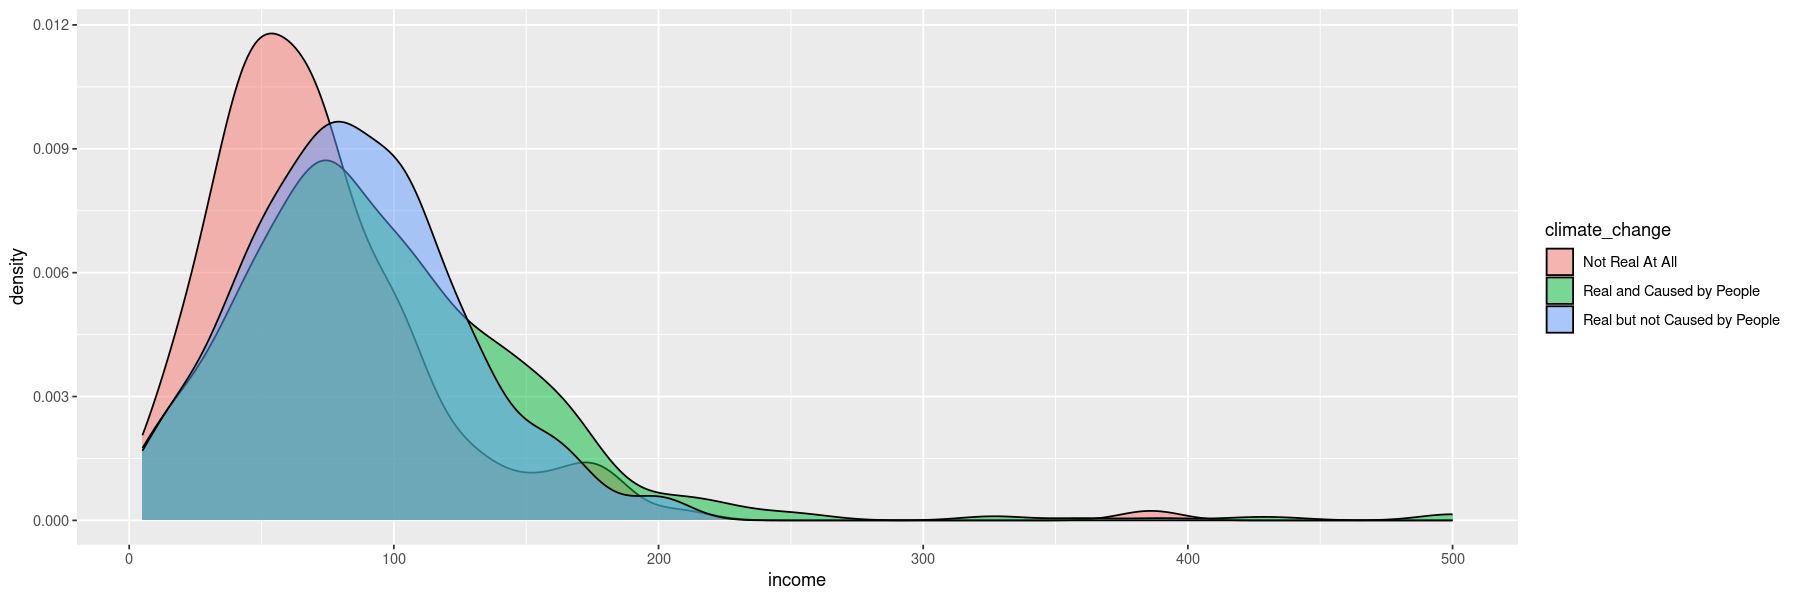

In [51]:
ggplot( climate_change_data ) + geom_density( aes(x=income, fill=climate_change ), alpha=0.5 )

There appears to be a slight relationship.

Age vs outcome:

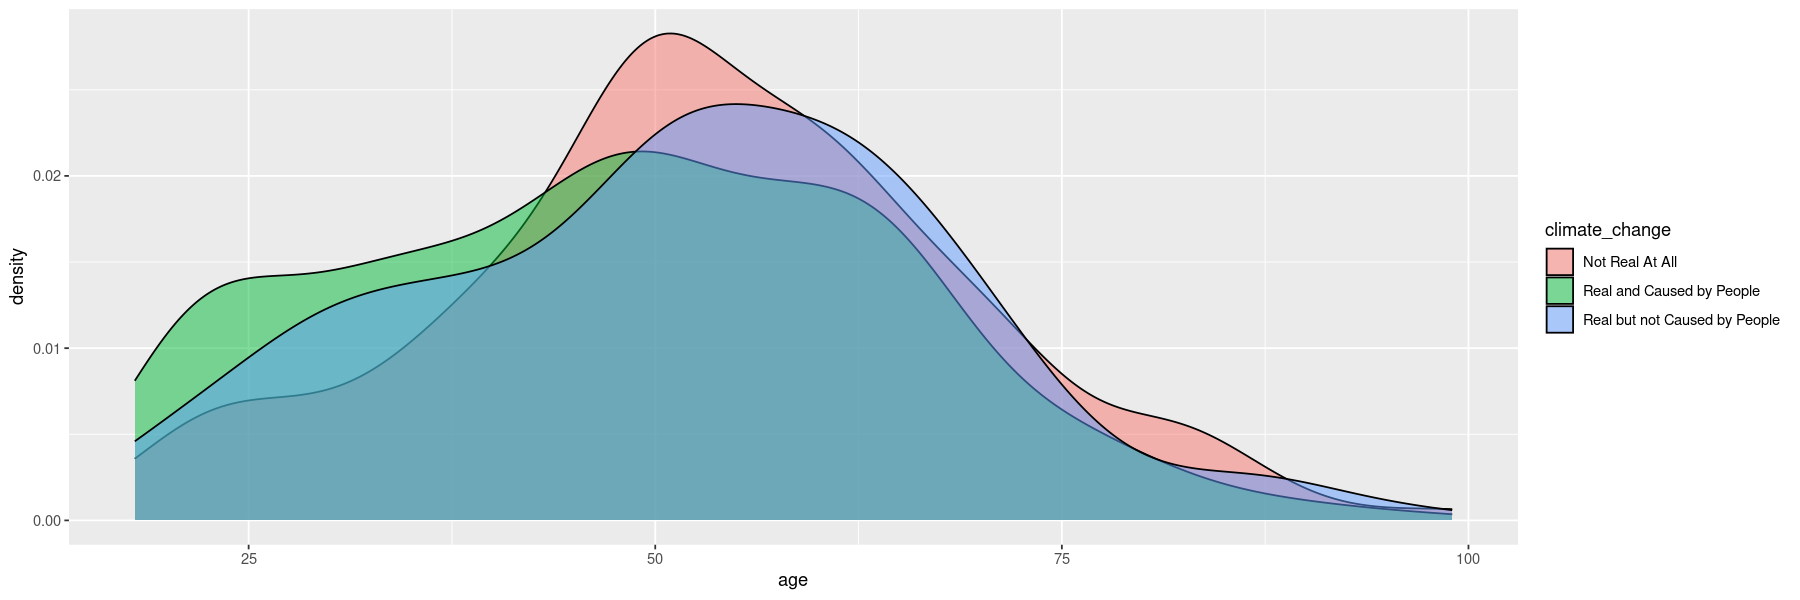

In [52]:
ggplot( climate_change_data ) + geom_density( aes(x=age, fill=climate_change ), alpha=0.5 )

Hard to see a relationship.

Party vs. outcome:

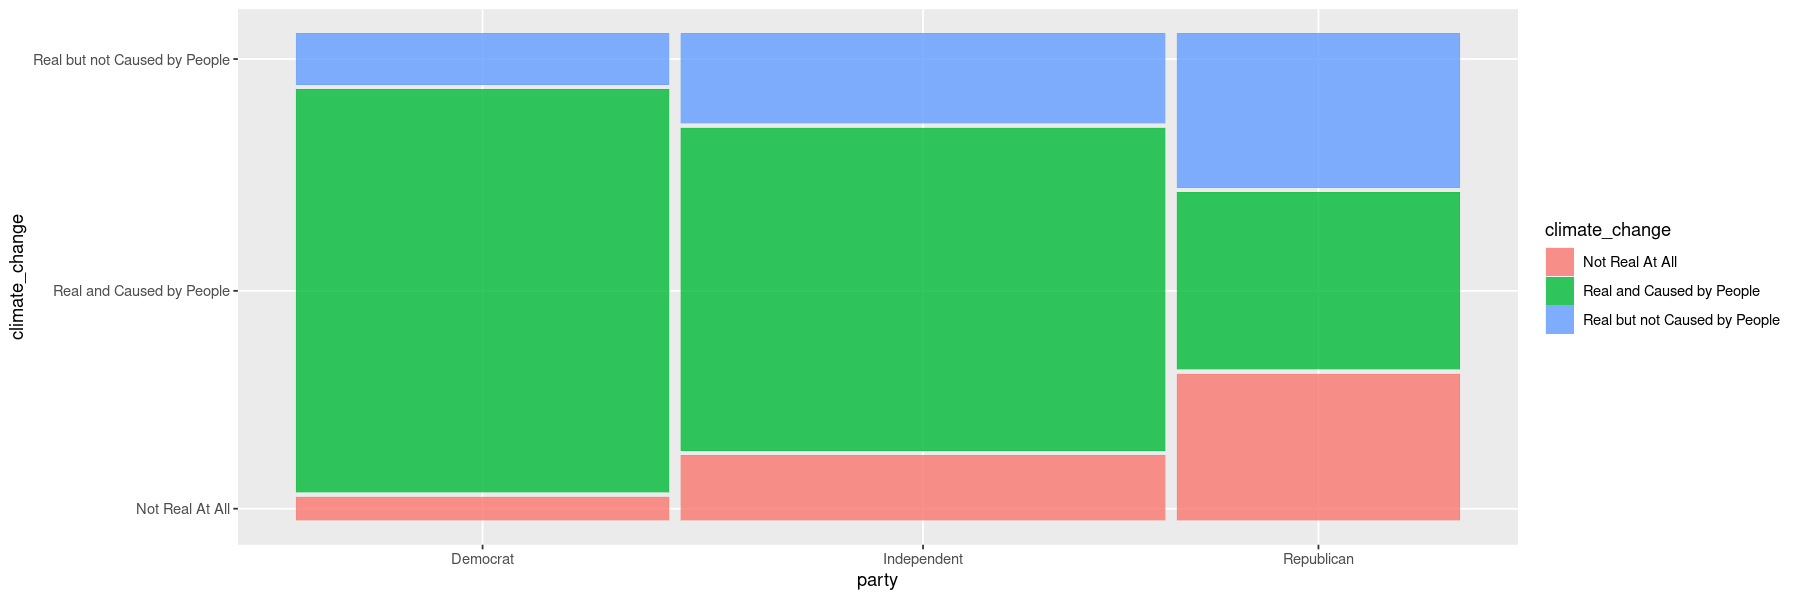

In [53]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=climate_change_data ) + geom_mosaic( aes(x=product(climate_change, party), fill=climate_change) )

Party has certainly a big impact (or the other way round..)

Trump approval vs outcome:

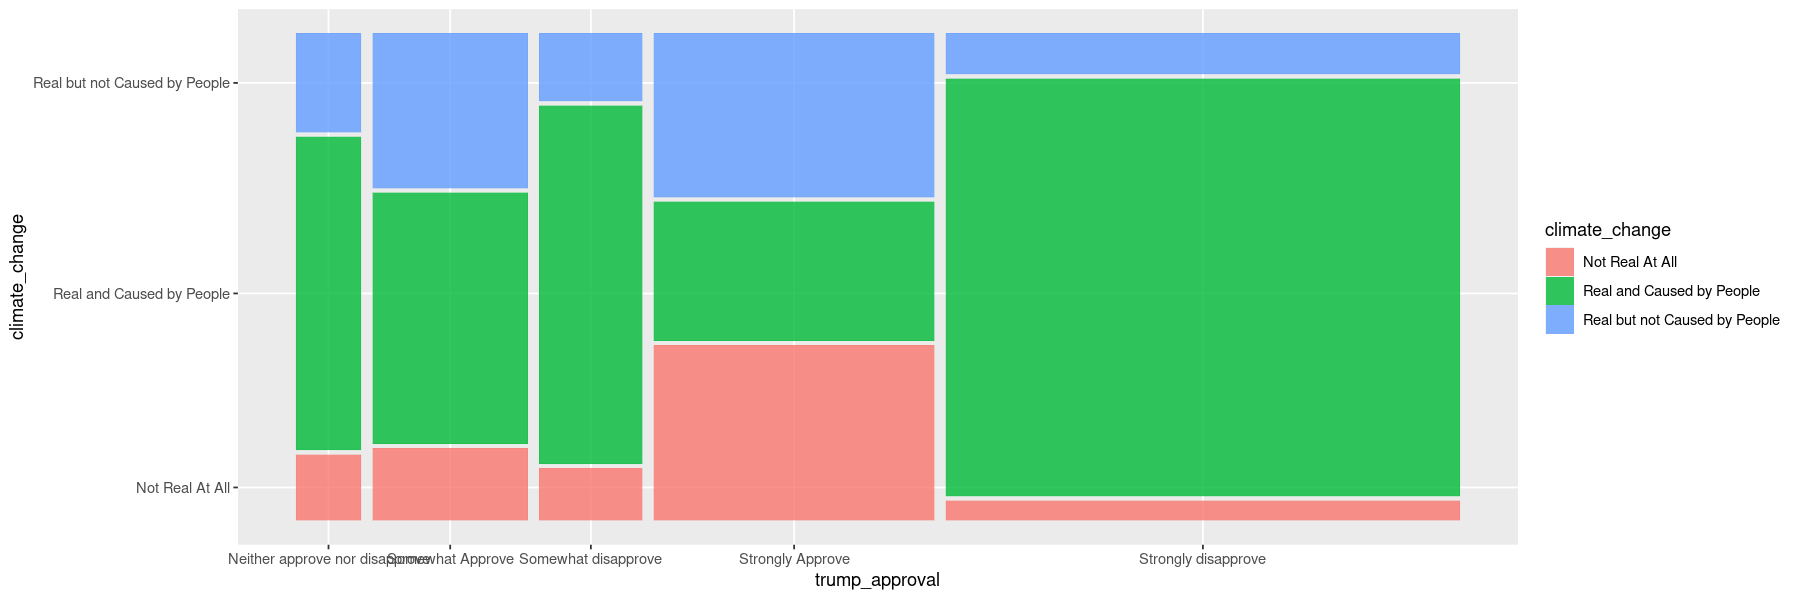

In [54]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=climate_change_data ) + geom_mosaic( aes(x=product(climate_change, trump_approval), fill=climate_change) )

Also here..

Education vs outcome:

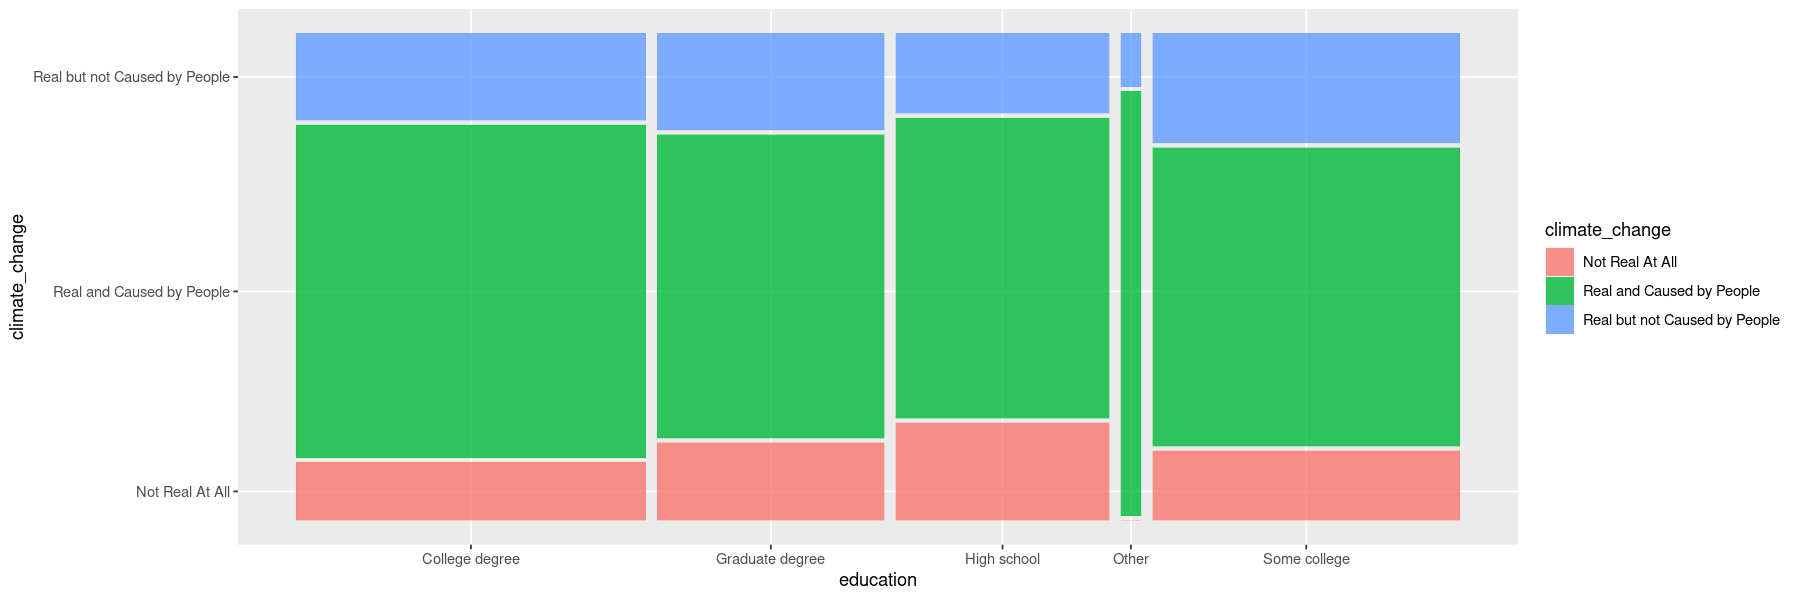

In [55]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=climate_change_data ) + geom_mosaic( aes(x=product(climate_change, education), fill=climate_change) )

Slight relationship..

### Fit and cross-validate model

In [56]:
climate_model_1 <- naiveBayes(climate_change ~ ., data=climate_change_data)
cv <- naive_classification_summary_cv( model=climate_model_1, data=climate_change_data, y="climate_change", k=10)
cv$cv

,climate_change,Not Real At All,Real and Caused by People,Real but not Caused by People
,<fct>,<chr>,<chr>,<chr>
1,Not Real At All,34.67% (52),35.33% (53),30.00% (45)
2,Real and Caused by People,6.11% (40),86.72% (568),7.18% (47)
3,Real but not Caused by People,25.64% (50),48.21% (94),26.15% (51)


In [57]:
table( climate_change_data$climate_change )


              Not Real At All     Real and Caused by People 
                          150                           655 
Real but not Caused by People 
                          195 

The model seems to be subject to the class imbalance in the data. One could tune the threshold of the model to get a target sensitivity.

## Exercise 14.11

### Select predictors

Selecting and dropping the same predictors as before. Probably we would get a better model with climate_change or science_is_honest, however I find it unlikely, that we get these opinions as separate data.

In [58]:
vaccine_data <- pulse_of_the_nation %>% 
    select( vaccines_are_safe, income, age, party, trump_approval, education )

### Exploratory data analysis

Income vs outome:

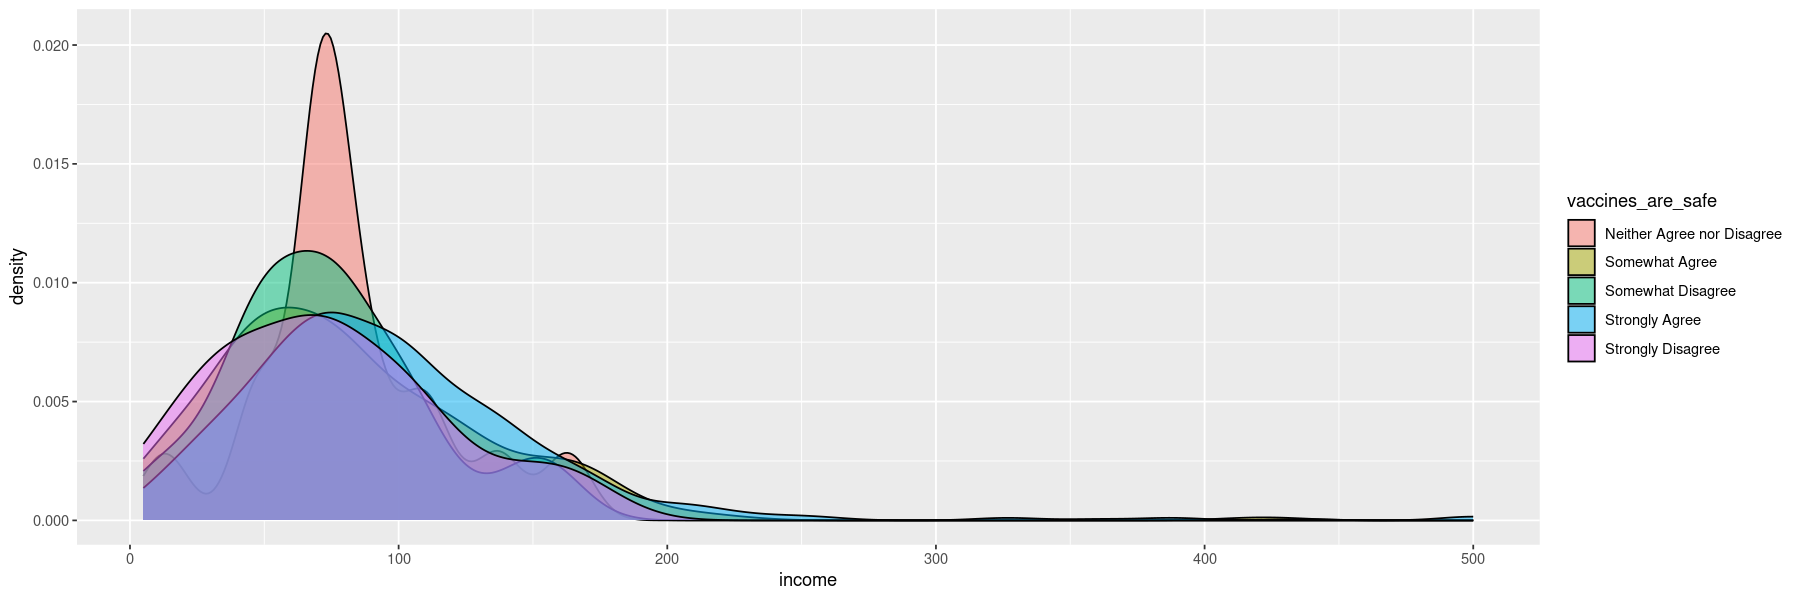

In [59]:
ggplot( vaccine_data ) + geom_density( aes(x=income, fill=vaccines_are_safe ), alpha=0.5 )

Hard to see good evidence for a significant relationship.

Age vs outcome:

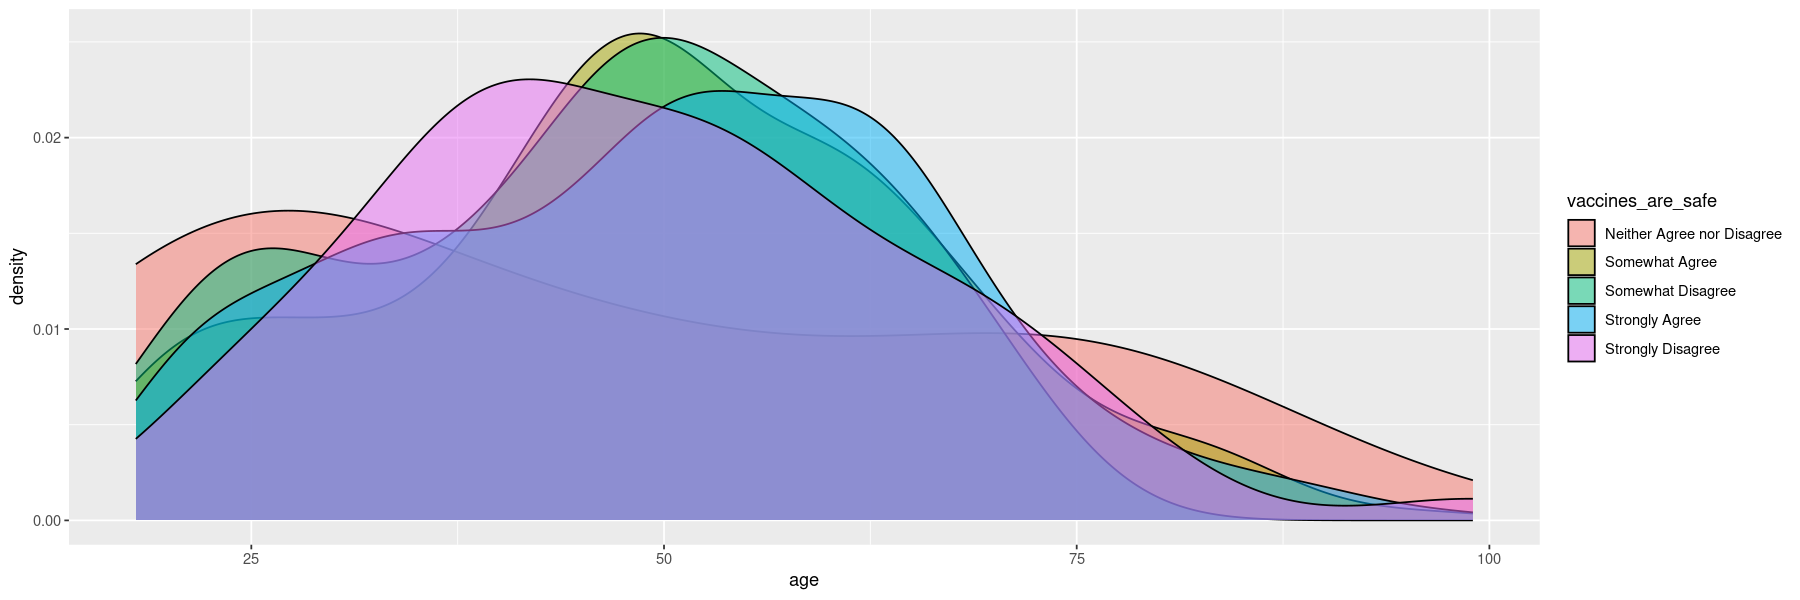

In [60]:
ggplot( vaccine_data ) + geom_density( aes(x=age, fill=vaccines_are_safe ), alpha=0.5 )

Hard to see a relationship.

Party vs. outcome:

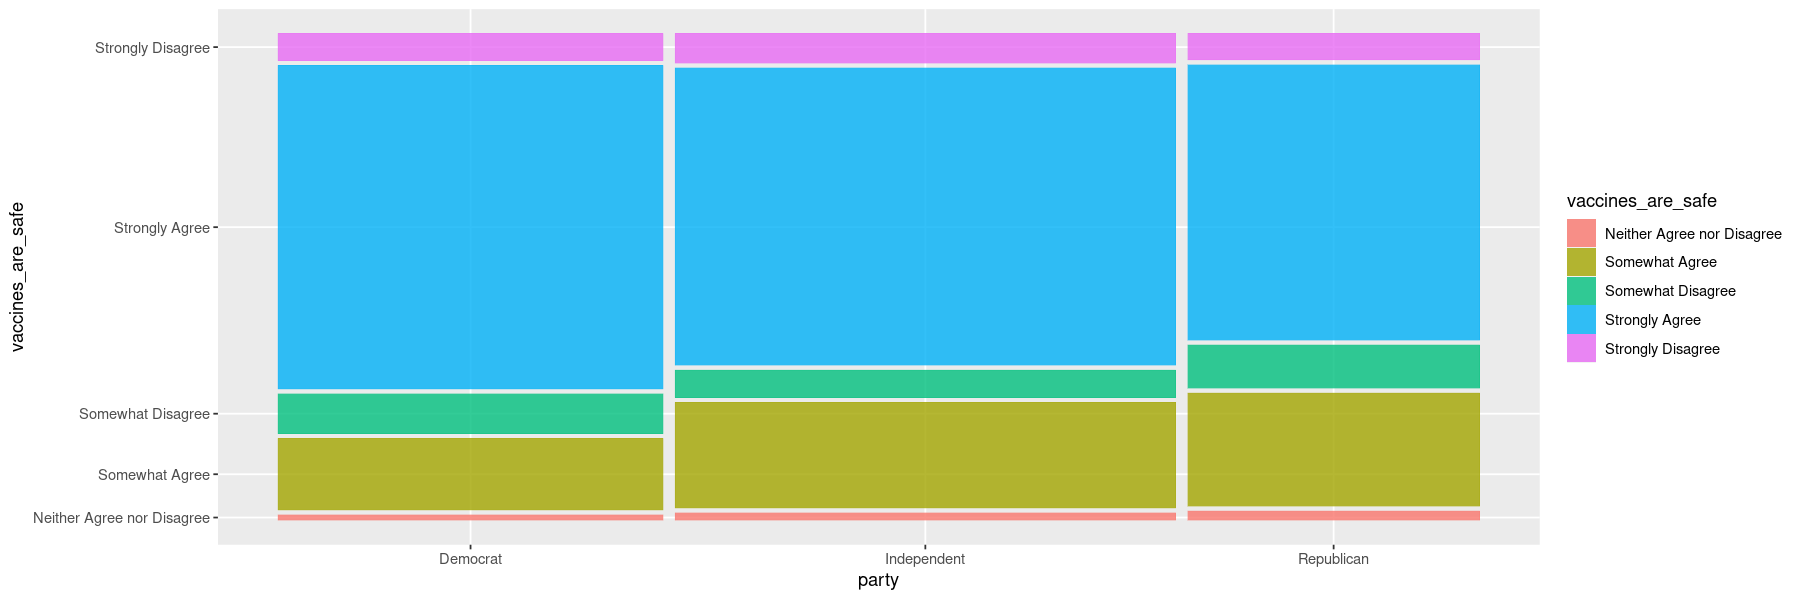

In [61]:
ggplot( data=vaccine_data ) + geom_mosaic( aes(x=product(vaccines_are_safe, party), fill=vaccines_are_safe) )

Slight relationship with party, smaller than with climate change.

Trump approval vs outcome:

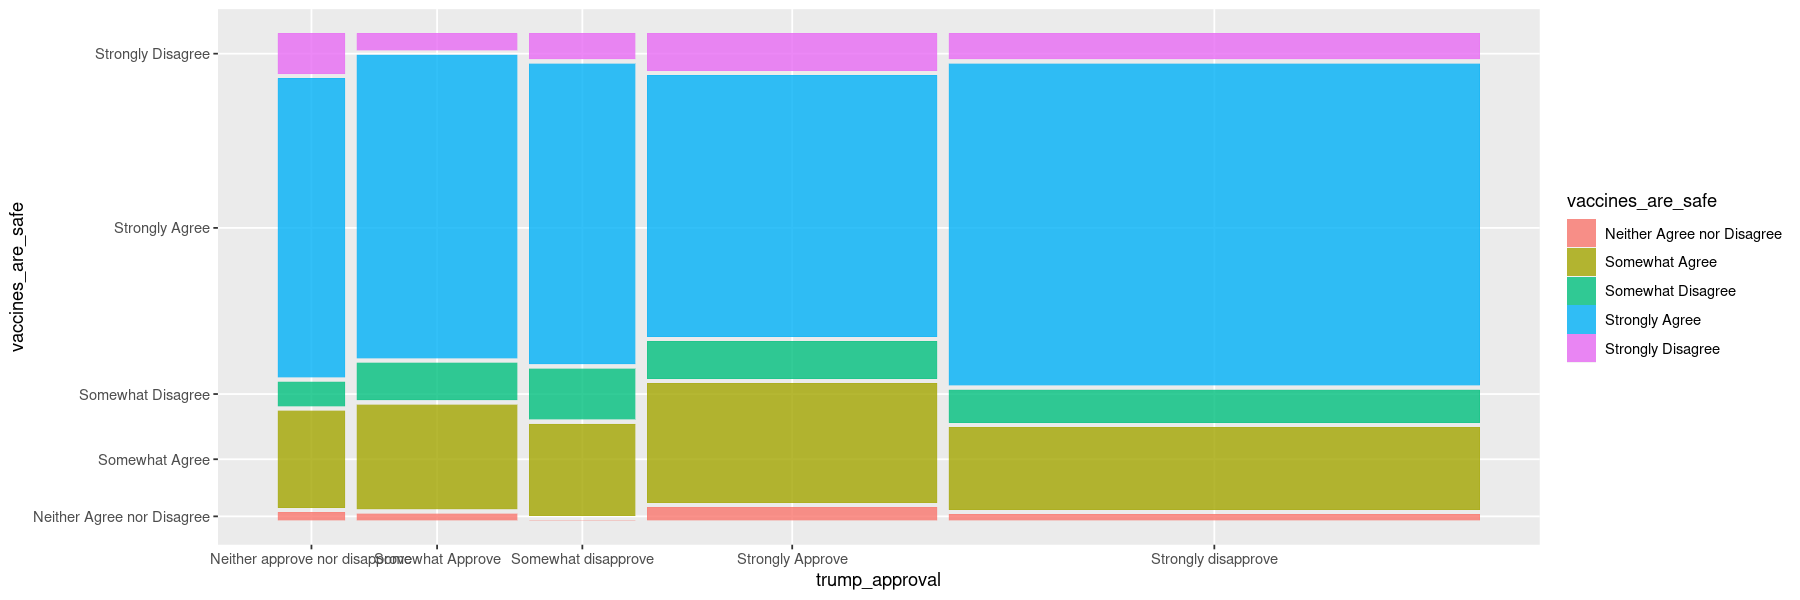

In [62]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=vaccine_data ) + geom_mosaic( aes(x=product(vaccines_are_safe, trump_approval), fill=vaccines_are_safe) )

Also here, interesting that still the vast majority believes that vaccines are safe.

Education vs outcome:

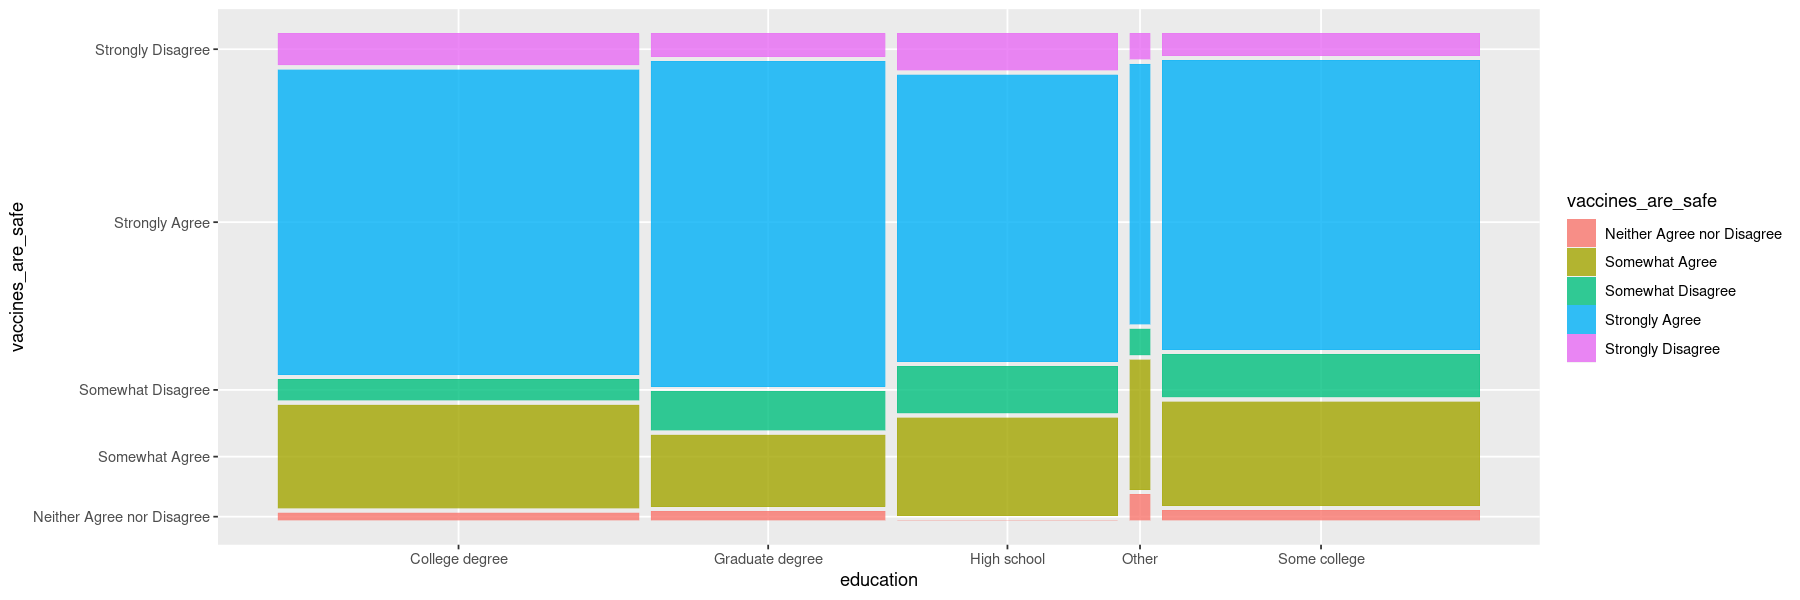

In [63]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=vaccine_data ) + geom_mosaic( aes(x=product(vaccines_are_safe, education), fill=vaccines_are_safe) )

Also here hard to say.

This model will probably be even worse than the one in the previous exercise.

### Fit and evaluate model

In [64]:
vaccine_model_1 <- naiveBayes(vaccines_are_safe ~ ., data=vaccine_data)
cv <- naive_classification_summary_cv( model=vaccine_model_1, data=vaccine_data, y="vaccines_are_safe", k=10)
cv$cv

,vaccines_are_safe,Neither Agree nor Disagree,Somewhat Agree,Somewhat Disagree,Strongly Agree,Strongly Disagree
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Neither Agree nor Disagree,0.00% (0),0.00% (0),0.00% (0),100.00% (16),0.00% (0)
2,Somewhat Agree,0.00% (0),0.00% (0),0.00% (0),100.00% (206),0.00% (0)
3,Somewhat Disagree,0.00% (0),0.00% (0),0.00% (0),100.00% (76),0.00% (0)
4,Strongly Agree,0.00% (0),0.62% (4),0.00% (0),99.38% (638),0.00% (0)
5,Strongly Disagree,0.00% (0),1.67% (1),0.00% (0),98.33% (59),0.00% (0)


In [65]:
table( vaccine_data$vaccines_are_safe )


Neither Agree nor Disagree             Somewhat Agree 
                        16                        206 
         Somewhat Disagree             Strongly Agree 
                        76                        642 
         Strongly Disagree 
                        60 

The model completely falls for class imbalance here. One could further tune the decision threshold to achieve different results, however it appears that `naive_classification_summary_cv()` does not support this yet.

In both of this and the previous exercise, significantly more time could invested if there were a good practical use case for applying the models at hand.